# pySPaRTAN: a Python computational framework for linking cell-surface receptors to transcriptional regulators

## Introduction

Cell identity and function are dependent on the complex signaling and transcriptional programs. Advances in single cell technology has enabled the transcriptional state analysis coupled with cell surface receptor expression. This tutorial will demo the usage of our computational framework SPaRTAN (Single-cell Proteomic and RAN-based Transcription factor Activity Network). SPaRTAN uses CITE-seq (Cellular Indexing of Transcriptomics and Epitopes by sequencing) data to link surface protein expression to inferred transcription factor activity. It models the flow of information from cell-surface receptors to transcription factors (TFs), and then regulate the target genes. More specifically, we use a regularized bilinear regression model to learn a cell-type specific interaction between cell surface protein and transcription factor activity that yields the best prediction of the target gene expression.

<img src="pySPaRTAN_diagram_1.png" alt="Diagram" width="600" />

## Environment setup

Suppose you have followed the instructions in README.txt and set up the Conda environment, installed JupyterLab, and the Python packages in requirements.txt.

First, we will install a few additional packages specific to this tutorial.
pySPaRTAN, a Python-based model, has optimized some computationally intensive Python functions by converting them into two platform-dependent Cython modules. 


Install Cython

In [ ]:
! pip install cython

Build two Cython objects. 

In [ ]:
! python  setup.py build_ext --inplace

After successfully building the Cython objects, there are two .so files generated on a Mac/Linux machine or .pyd files on a Windows machine.

In [ ]:
! ls 

Lastly, we will install the pySPaRTAN package.

In [ ]:
! pip install pySPaRTAN

## Generating pySPaRTAN input data

### Importing and preprocessing CITE_seq data

In [42]:
import scanpy as sc
from muon import prot as pt
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from sklearn.preprocessing import normalize

from IPython.display import display, HTML
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from itertools import chain
from adjustText import adjust_text

import pySPaRTAN

#### Importing data
We demonstrate the pipeline using the CITE-seq dataset of Peripheral Blood Mononuclear Cells (PBMC), which is freely available from 10X Genomics.

In [43]:
# loading CITE-seq data
adata=sc.read_10x_h5("../data/5k_pbmc_protein_v3_nextgem_filtered_feature_bc_matrix.h5", gex_only=False)
adata.var_names_make_unique()

#### Extracting ADT(protein) and gene expression

Extracting the ADT

In [44]:
ADT=adata[:,adata.var["feature_types"]=="Antibody Capture"].copy()

# removing the isotype control for antibody
ADT=ADT[:,[x for x in ADT.var_names if "control" not in x]]

Extracting gene expression

In [45]:
RNA = adata[:, adata.var["feature_types"] == "Gene Expression"]

Performing quality control

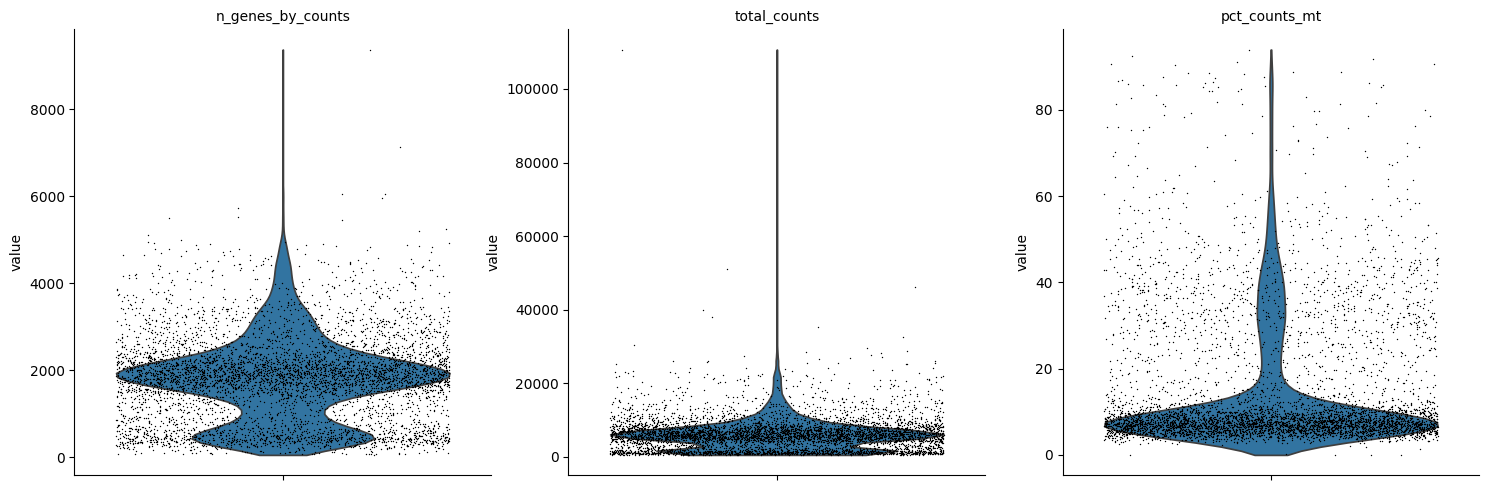

In [46]:
RNA.var['mt'] = RNA.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(RNA, qc_vars=['mt'], percent_top=None, log1p=False,inplace=True)

sc.pl.violin(
    RNA,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

In [47]:
sc.pp.filter_genes(RNA, min_cells=0.03*RNA.n_obs)
sc.pp.filter_cells(RNA, min_genes=1000)
RNA=RNA[RNA.obs.query("n_genes_by_counts < 5500 and pct_counts_mt<30").index]

# we also remove all mitoconondrial genes from the datset
RNA=RNA[:, RNA.var['mt']==False]

# Filter cells of ADT according to RNA
ADT = ADT[RNA.obs_names, :]

Normalizing data

In [48]:
# normalizing RNA
sc.pp.normalize_total(RNA, target_sum=10000)
sc.pp.log1p(RNA)

# normalizing ADT
pt.pp.clr(ADT)

#### Annotating Cell type

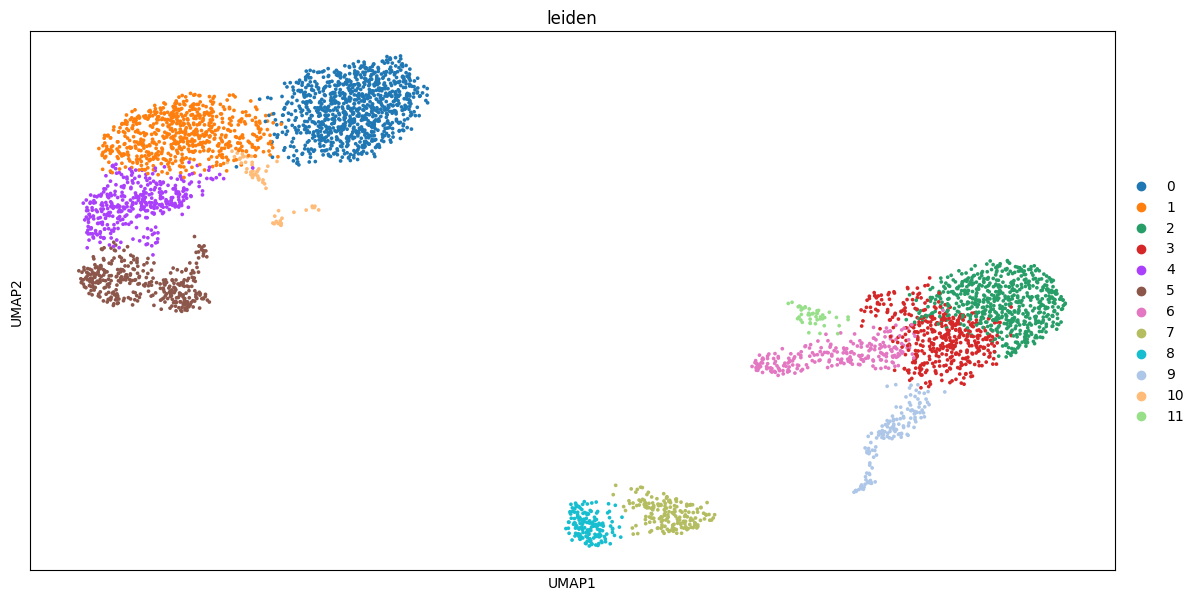

In [49]:
# saving normalized RNA 
RNA.layers['log1p'] = RNA.X.copy()
# Identifying highly variable features
sc.pp.highly_variable_genes(RNA, n_top_genes=5000, subset=False)
# Scaling the data
sc.pp.scale(RNA)
# Performing linear dimensional reduction
sc.tl.pca(RNA)
# Computing neighborhood graph
sc.pp.neighbors(RNA)
# Performing non-linear dimensional reduction
sc.tl.umap(RNA)
# Clustering
sc.tl.leiden(RNA, flavor="leidenalg")
sc.pl.umap(RNA, color=["leiden"])

We annotated the cell types based on the below marker genes and proteins. The process involved multiple iteration of subclustering and re-annotation, it's difficult to show the entire process. 

In [50]:

display(HTML('<header class="u-mb-16"><h4 class="c-article-satellite-title u-h1" id="table-2-title">Marker genes used to assign cell types to clusters</h4></header><div class="c-article-table-container"><div class="c-article-table-border c-table-scroll-wrapper"><div class="c-table-scroll-wrapper__content" data-component-scroll-wrapper=""><table class="data last-table"><thead class="c-article-table-head"><tr><th class="u-text-left "><p>Cell type</p></th><th class="u-text-left "><p>Marker genes</p></th><th class="u-text-left "><p>Marker proteins</p></th></tr></thead><tbody><tr><td class="u-text-left "><p>CD8+</p></td><td class="u-text-left "><p><i>CD8A</i>, <i>CD8B</i>, <i>FCER1G</i></p></td><td class="u-text-left "><p>CD8a, CD4</p></td></tr><tr><td class="u-text-left "><p>Naive CD4+ T</p></td><td class="u-text-left "><p><i>IL7R</i>, <i>CCR7</i>, <i>CD3E</i></p></td><td class="u-text-left "><p>CD45RA, CD4</p></td></tr><tr><td class="u-text-left "><p>Memory CD4+</p></td><td class="u-text-left "><p><i>IL7R</i>, <i>S100A4</i>, <i>CD3E</i></p></td><td class="u-text-left "><p>CD45RO, CD4</p></td></tr><tr><td class="u-text-left "><p>NK</p></td><td class="u-text-left "><p><i>GNLY</i>, <i>NKG7</i></p></td><td class="u-text-left "><p>CD56</p></td></tr><tr><td class="u-text-left "><p>DC</p></td><td class="u-text-left "><p><i>FCER1A</i>, <i>CST3</i></p></td><td class="u-text-left "> </td></tr><tr><td class="u-text-left "><p>CD14+ Mono</p></td><td class="u-text-left "><p><i>CD14</i>, <i>LYZ</i></p></td><td class="u-text-left "><p>CD14</p></td></tr><tr><td class="u-text-left "><p>FCGR3A+/CD16+ Mono</p></td><td class="u-text-left "><p><i>FCGR3A</i>, <i>MS4A7</i></p></td><td class="u-text-left "><p>CD16</p></td></tr><tr><td class="u-text-left "><p>B</p></td><td class="u-text-left "><p><i>MS4A1</i></p></td><td class="u-text-left "><p>CD20, CD19</p></td></tr></tbody></table></div></div></div><div class="u-text-right"></div>'))


Cell type,Marker genes,Marker proteins
CD8+,"CD8A, CD8B, FCER1G","CD8a, CD4"
Naive CD4+ T,"IL7R, CCR7, CD3E","CD45RA, CD4"
Memory CD4+,"IL7R, S100A4, CD3E","CD45RO, CD4"
NK,"GNLY, NKG7",CD56
DC,"FCER1A, CST3",
CD14+ Mono,"CD14, LYZ",CD14
FCGR3A+/CD16+ Mono,"FCGR3A, MS4A7",CD16
B,MS4A1,"CD20, CD19"


We load the saved cell_type annotation file. 

In [51]:
df_ct = pd.read_csv("../data/cell_types_PBMC.csv", index_col=0)

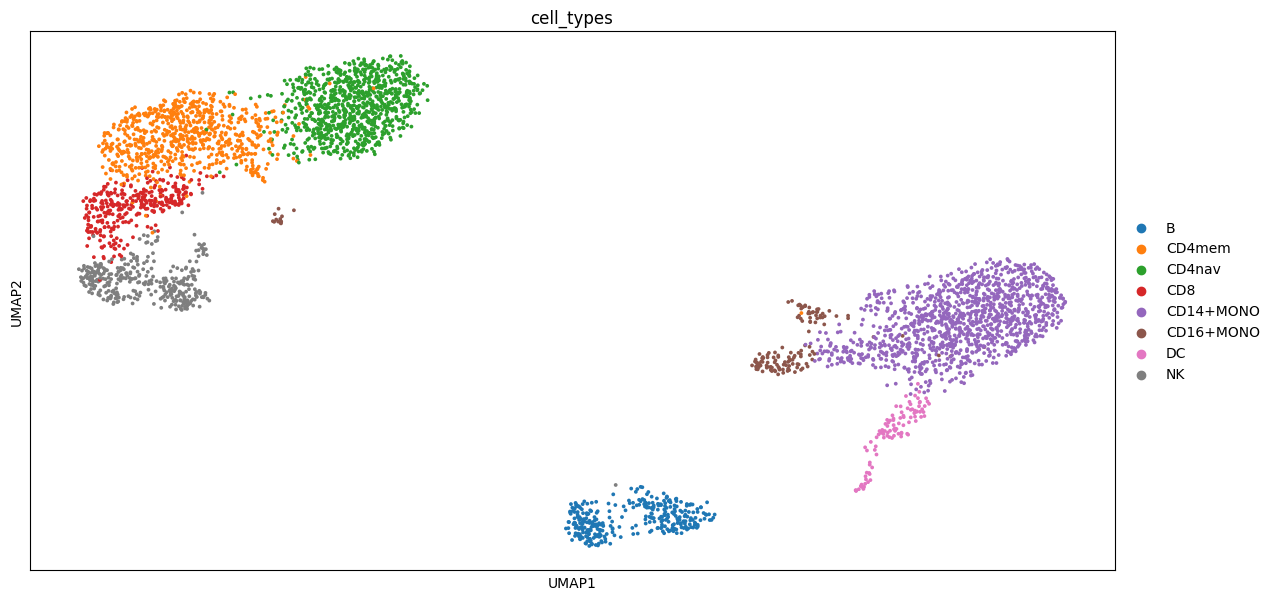

In [52]:
RNA=RNA[np.intersect1d(RNA.obs_names, df_ct.index)] 
RNA.obs["cell_types"] = df_ct.loc[RNA.obs_names]
sc.pl.umap(RNA, color=["cell_types"])

In [53]:
RNA.obs["cell_types"].value_counts()

cell_types
CD14+MONO    1201
CD4nav        907
CD4mem        702
NK            352
B             332
CD8           318
CD16+MONO     140
DC            100
Name: count, dtype: int64

# Reviewing pySPaRTAN model
<img src="pySPaRTAN_diagram_2.png" alt="Diagram" width="600" />


There are three inputs for the package: D, P Y

D: gene-tf matrix.

P: cell x ADT matrix. 

Y: gene x cell matrix, 

After training the model, we obtain the learned TF and protein interaction matrix W.

<img src="pySPaRTAN_diagram_3.png" alt="Diagram" width="600" />

From matrix W we can 
1. generate inferred TF activity
   
   infer_TF = W * Pt

2. generate inferred protein expression

   infer_protein = Y * D * W


Loading gene-TF matrix

In [54]:
# pySPaRTAN model contains the gene-TF matrix for PBMC dataset
geneTF = pySPaRTAN.datasets.load_dorthea()
geneTF.shape

(2643, 255)

Note: SPaRTAN model requires log normalized RNA expression as input. Current RNA.X has been scaled during cell type annotation, we need to load the normalized data back to RNA.X

In [55]:
RNA.X = RNA.layers['log1p']
# Aligning the genes in RNA with those in geneTF matrix
RNA = RNA[:, geneTF.index]

The pySPaRTAN model performs best when applied separately to data from different cell types. We will extract RNA and ADT data for each cell type.

In [56]:
RNAs={}; ADTs={}
for celltype in set(df_ct["cell_types"]):
    index_type = df_ct.index[df_ct["cell_types"]==celltype]
    RNA_type = RNA[RNA.obs_names.isin(index_type)].to_df()
    ADT_type = ADT[ADT.obs_names.isin(index_type)].to_df()

    RNAs[celltype] = RNA_type
    ADTs[celltype] = ADT_type

RNAs.keys()

dict_keys(['CD14+MONO', 'NK', 'CD16+MONO', 'DC', 'CD4nav', 'B', 'CD4mem', 'CD8'])

In [57]:
RNAs['CD8']

,NOC2L,ISG15,TNFRSF18,ACAP3,DVL1,AURKAIP1,MRPL20,MIB2,CDK11A,NADK,...,TRAPPC10,PFKL,TRPM2,SUMO3,PTTG1IP,ITGB2,ADARB1,COL18A1,SLC19A1,S100B
AACACACCAATCCTAG-1,1.553033,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.553033,0.000000,0.0,1.553033,0.0,1.553033,0.000000,0.0,0.000000,0.000000
AACAGGGAGCGAAACC-1,0.889916,0.000000,0.0,0.0,0.0,0.000000,1.353216,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.889916,0.0,1.353216,0.000000,0.0,0.889916,0.000000
AACCAACTCGAGTACT-1,1.128693,0.000000,0.0,0.0,0.0,1.128693,0.000000,1.645427,1.128693,0.000000,...,0.000000,0.000000,0.0,1.128693,0.0,1.128693,0.000000,0.0,0.000000,2.875422
AACCATGCAATGCAAA-1,0.000000,0.000000,0.0,0.0,0.0,1.068981,1.068981,0.000000,0.000000,0.000000,...,0.000000,1.068981,0.0,1.068981,0.0,1.573774,0.000000,0.0,0.000000,0.000000
AACGGGAGTGAGATAT-1,1.605132,1.941296,0.0,0.0,0.0,1.095025,0.000000,1.095025,0.000000,0.000000,...,0.000000,1.095025,0.0,0.000000,0.0,1.941296,0.000000,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGTTCAGTAATGCTC-1,0.000000,2.730933,0.0,0.0,0.0,0.953253,0.000000,0.953253,0.000000,0.000000,...,0.953253,0.000000,0.0,0.000000,0.0,0.953253,0.000000,0.0,0.000000,0.000000
TTGTTGTGTACCTTCC-1,0.000000,2.000282,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1.141154,...,0.000000,1.141154,0.0,0.000000,0.0,2.767115,1.141154,0.0,0.000000,0.000000
TTGTTTGTCGACCCAG-1,0.000000,1.149485,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,1.149485,0.0,1.149485,0.000000,0.0,0.000000,0.000000
TTTAGTCTCGGTGCAC-1,0.000000,1.399680,0.0,0.0,0.0,0.000000,1.399680,0.927013,1.399680,0.000000,...,0.000000,0.927013,0.0,0.927013,0.0,1.961193,0.000000,0.0,0.000000,0.000000


### Running pySPaRTAN
After preparing the input for pySPaRTAN, we are ready to run the model. We will use the CD8 T cell to demonstrate the procedure.

In [58]:
ct = "CD8"
D = geneTF.copy()
P = ADTs[ct].copy()
Y = RNAs[ct].copy()

In [59]:
D.shape, P.shape, Y.shape

((2643, 255), (318, 29), (318, 2643))

We train the model using 80% of all cells in the dataset. The remaining 20% will be reserved for testing to evaluate the model’s performance.

In [60]:
P_train, P_test, Y_train, Y_test = train_test_split(
    P, Y, test_size=0.2, random_state=0)

pySPaRTAN is a bilinear model that incorporates three hyperparameters: lambda, alpha, and spectrum. Lambda and alpha control the trade-off between L1 and L2 regularization. Spectrum controls the truncation of the P matrix through singular value decomposition. For example, setting spectrum=0.7 specifies the number of singular vectors capturing 70% of the full spectrum

For optimization, we employ cross-validation and grid search to determine the optimal values of lambda (ranging from 1e-5 to 10) and alpha (ranging from 0 to 1). The spectrum parameter requires less tuning; hence, we fix it at 0.7.

Upon initializing the model, we define the ranges for lambda and alpha as follows:

In [61]:
model= pySPaRTAN.SPaRTAN(lamda=[0.0001,10],
                                 alpha=[0,1],
                                 spectrum=0.7)


Training the model by calling the fit function

In [62]:
model.fit(Y=Y_train,P=P_train, D=D)

After training the model on the training dataset, we evaluate its ability to predict gene expression based on protein expression using the testing dataset

In [63]:
model.score(P=P_test.values, Y=Y_test.values)

0.7023389931241151

This score is the correlation between predicted gene expression and observed gene expression, serving as the evaluation metric for prediction performance.

Now, we obtain the inferred TF activity for all cells of a given cell type based on the protein expression of that cell type.

In [64]:
tf =model.get_projD(P)
tf

,CREB1,JUN,TEAD1,FOS,RXRA,PBX3,MYC,RARA,PPARG,PAX6,...,SMARCC1,KMT2B,FOXO4,SSRP1,SMAD5,ZNF274,UBTF,ZNF592,TGIF2,GATAD1
AACACACCAATCCTAG-1,1.226296,-0.163579,-0.669905,0.015051,-0.471956,0.884063,1.354958,0.877170,1.690954,-0.090931,...,0.765459,-0.466617,-0.190810,2.737739,0.147338,1.355813,0.733725,-0.488026,-0.283021,0.549926
AACAGGGAGCGAAACC-1,1.991859,0.148590,-0.913389,0.162453,-0.574769,1.198589,2.303498,1.214138,2.157497,0.145155,...,1.001782,-0.743922,-0.124074,4.364107,0.339144,2.094672,1.078792,-0.764874,-0.282886,0.768345
AACCAACTCGAGTACT-1,0.921310,0.120580,-0.422416,0.302315,-0.223219,0.635675,1.713642,0.680313,1.183102,0.177788,...,0.604068,-0.376812,-0.177521,3.030722,0.199396,1.093166,0.420424,-0.328489,-0.155862,0.356344
AACCATGCAATGCAAA-1,2.092991,0.069866,-0.888056,0.004670,-0.618197,1.342437,1.626433,1.162291,2.182850,-0.102720,...,0.993052,-0.707172,-0.018192,4.155375,0.450223,2.240897,1.137607,-0.602451,-0.203379,0.886134
AACGGGAGTGAGATAT-1,2.133812,0.019559,-0.987669,0.003863,-0.677155,1.254711,2.054547,1.195853,2.190817,-0.054088,...,1.003663,-0.736596,-0.094965,4.304724,0.405228,2.240144,1.133128,-0.690920,-0.233296,0.833336
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGTTCAGTAATGCTC-1,2.529706,0.233755,-1.043843,-0.035928,-0.679920,1.440903,2.103400,1.374191,2.341740,-0.052476,...,1.069531,-0.809381,0.007718,4.888786,0.552511,2.567524,1.221590,-0.685605,-0.215185,0.964665
TTGTTGTGTACCTTCC-1,1.728357,-0.106439,-0.969554,0.055169,-0.628829,1.173327,1.979750,1.141259,2.399709,0.074781,...,1.131741,-0.671887,-0.376253,4.079343,0.219466,1.813377,0.975537,-0.738740,-0.447097,0.649669
TTGTTTGTCGACCCAG-1,1.317829,0.166612,-0.682354,0.231484,-0.349348,0.892449,2.038387,0.939772,1.702260,0.089861,...,0.866468,-0.491215,-0.186353,4.301342,0.399907,1.631902,0.580605,-0.385809,-0.199125,0.536364
TTTAGTCTCGGTGCAC-1,1.763570,-0.219219,-0.824570,0.233155,-0.587186,1.338458,1.738470,1.056614,2.217581,0.146225,...,1.030171,-0.703197,-0.189909,3.861082,0.251800,1.874120,1.086473,-0.721291,-0.345770,0.750465


### Analyzing results

Here we explore the associations between inferred TF activity and surface protein expression at a single-cell level.

We first compute Pearson correlation coefficients between inferred TF activity and surface protein expression for each TF-protein pair within the cell-type

In [65]:
tf_protein = model.get_tf_protein_cor()
tf_protein

,CD3_TotalSeqB,CD4_TotalSeqB,CD8a_TotalSeqB,CD11b_TotalSeqB,CD14_TotalSeqB,CD15_TotalSeqB,CD16_TotalSeqB,CD19_TotalSeqB,CD20_TotalSeqB,CD25_TotalSeqB,...,CD86_TotalSeqB,CD127_TotalSeqB,CD137_TotalSeqB,CD197_TotalSeqB,CD274_TotalSeqB,CD278_TotalSeqB,CD335_TotalSeqB,PD-1_TotalSeqB,HLA-DR_TotalSeqB,TIGIT_TotalSeqB
CREB1,0.064873,-0.398437,0.751012,-0.267900,0.206241,0.039642,0.023219,0.143665,0.518049,0.208641,...,0.165454,0.182978,0.280875,0.184620,0.037595,0.292696,0.027284,0.297734,0.221217,0.470800
JUN,0.239669,0.480697,-0.600197,-0.094824,0.078934,0.177447,-0.140632,0.054109,0.185468,0.180230,...,-0.153470,0.746919,-0.113145,0.097727,0.174767,0.037011,-0.023873,0.162936,-0.262744,-0.405622
TEAD1,-0.069149,0.435902,-0.779560,0.098410,-0.214421,-0.097699,-0.102901,-0.172780,-0.404040,-0.195876,...,-0.194676,-0.065788,-0.265717,-0.243935,-0.101734,-0.231685,-0.143468,-0.300118,-0.245937,-0.559021
FOS,0.259017,0.534034,-0.491154,0.153549,-0.075917,0.050620,0.007370,0.093022,-0.307332,-0.034786,...,-0.122332,-0.049952,-0.118350,-0.146130,0.088694,0.258840,-0.026664,0.005138,-0.123138,-0.325505
RXRA,0.036353,0.429998,-0.806192,0.172755,-0.158282,-0.010721,-0.025735,-0.121486,-0.361629,-0.128967,...,-0.179428,0.032527,-0.311133,-0.178778,-0.008175,-0.248234,-0.079411,-0.320015,-0.249846,-0.617316
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZNF274,0.140884,-0.178218,0.580058,-0.287464,0.220378,0.119895,-0.010489,0.174694,0.469996,0.186106,...,0.187497,0.312818,0.337288,0.246348,0.076349,0.430314,0.020591,0.485286,0.249861,0.435055
UBTF,-0.054969,-0.291485,0.798013,-0.259049,0.160628,-0.007690,0.011014,0.154530,0.397213,0.113068,...,0.181434,0.066057,0.270454,0.160043,0.032959,0.411837,0.005699,0.392732,0.232160,0.574333
ZNF592,-0.025068,0.631934,-0.945182,0.041994,-0.141652,0.041217,-0.103887,-0.093120,-0.268422,-0.097997,...,-0.138811,0.200318,-0.125620,-0.114364,0.012158,-0.128067,-0.104603,0.099288,-0.198193,-0.526288
TGIF2,-0.120895,0.352382,-0.590446,-0.105961,-0.092833,-0.093021,-0.233861,-0.157893,-0.022145,-0.017614,...,-0.105208,0.488916,-0.030412,-0.026422,-0.153010,-0.072721,-0.307323,0.133291,-0.148018,-0.618622


Trim the end of protein names

In [66]:
tf_protein.columns = tf_protein.columns.str[:-10]
tf_protein.columns

Index(['CD3', 'CD4', 'CD8a', 'CD11b', 'CD14', 'CD15', 'CD16', 'CD19', 'CD20',
       'CD25', 'CD27', 'CD28', 'CD34', 'CD45RA', 'CD45RO', 'CD56', 'CD62L',
       'CD69', 'CD80', 'CD86', 'CD127', 'CD137', 'CD197', 'CD274', 'CD278',
       'CD335', 'PD-1', 'HLA-DR', 'TIGIT'],
      dtype='object')

We filter out the TF and protein with lower absolute correlation values 

In [67]:
proteins_to_plot = tf_protein.columns[abs(tf_protein).max(axis=0) > 0.7]
tfs_to_plot = tf_protein.index[abs(tf_protein).max(axis=1) > 0.8]
tf_protein_plot = tf_protein.loc[tfs_to_plot, proteins_to_plot]

Then we plot heatmap of the selected protein-TF correlation

Text(0.5, 1.05, 'CD8 T cell protein-TF correlation')

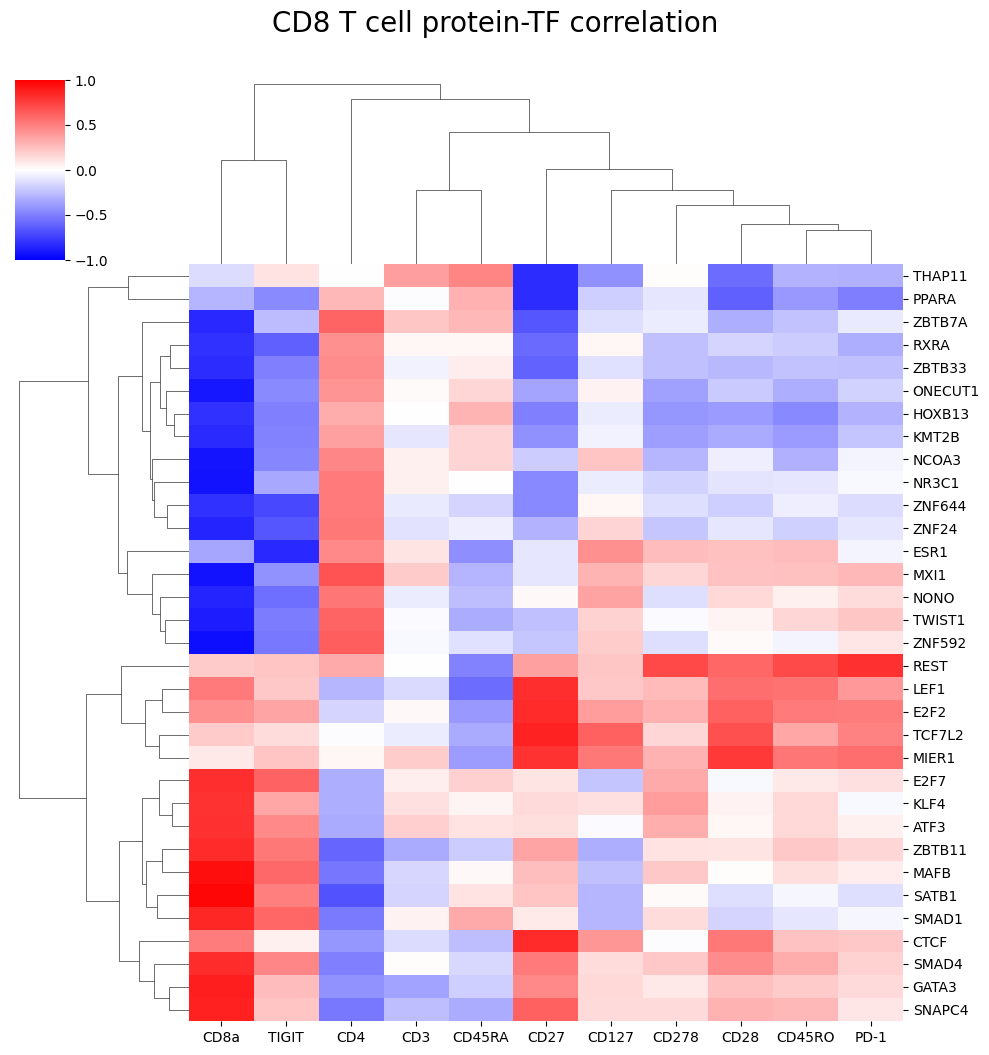

In [68]:
sns.clustermap(
    tf_protein_plot,
    cmap="bwr",vmin=-1, vmax=1
).fig.suptitle(ct + " T cell protein-TF correlation", y=1.05,fontsize=20)

Finally, we plot the TF correlation with specific protein, highlight the TFs with highest and lowest correlations.

Defining the plot function

In [69]:
def line_plot(pcc,prot, N, ax):
    
    pcc_prot = pcc.loc[:, prot].sort_values()

    labels = pcc_prot

    x= range(1,len(pcc_prot)+1)
    y=pcc_prot
    l=pcc_prot.index
    ax.scatter(x, y, s=8)

    range_c = chain(range(0,N), range(len(x)-N, len(x)))
    texts = [ax.text(x[i], y[i], '%s' %l[i], ha='center', va='center', fontsize=10) for i in range_c]
    adjust_text(texts, arrowprops=dict(arrowstyle="-", color='r'), ax=ax, min_arrow_len=0, time_lim=0.1)

    ax.set_xlabel("TF ranking", fontsize=15)
    ax.set_ylabel(f"Corr between {prot} exp and TF activity", fontsize=15)
    ax.set_title(prot)

    range_c = chain(range(0,N), range(len(x)-N, len(x)))
    TF_labels = [l[i] for i in range_c]
    return(TF_labels)


Plotting lineplot

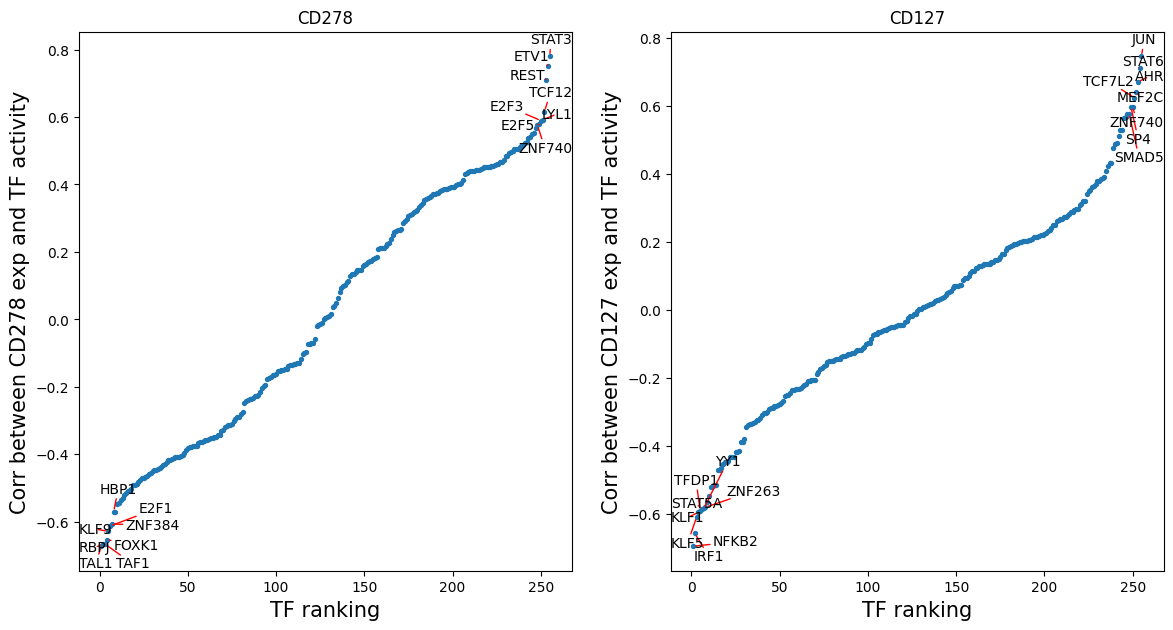

In [70]:
plt.rcParams['figure.figsize'] = [14, 7]
fig, ax = plt.subplots(1,2)
prot = "CD278"
line_plot(tf_protein, prot, 8, ax[0])
prot = "CD127"
line_plot(tf_protein, prot, 8, ax[1])

fig.show()
